# 0. Import libraries

In [81]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import Counter

import math
from math import radians, sin, cos, asin, sqrt

import re
from re import findall
import datetime as dt

# для нормализации, стандартизации
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import category_encoders as ce

pd.set_option('display.max_columns', 200)  # показывать больше колонок

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Загружаем лингвистические библиотеки для обработки тестов отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/daria/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
TARGET_NAME = 'reviewer_score'

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Import datasets

In [4]:
# Подгрузим наши данные из соревнования

df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

In [5]:
print(df_train.info())
df_train.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [6]:
print(df_test.info())
df_test.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [7]:
print(sample_submission.info())
sample_submission.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB
None


,reviewer_score,id
0,1,488440
1,10,274649


# 2. EDA

## 2.0. Functions, dictionaries and constants

In [8]:
# функция создает единый список из списков
def list_unrar(list_of_lists):
    result=[]
    for lst in list_of_lists:
        result.extend(lst)
    return result

In [9]:
# Словари с с пропущенными координатами по адресам отелей
lat_dict = {'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': 48.215178,
       '23 Rue Damr mont 18th arr 75018 Paris France': 48.884582,
       'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': 48.209650,
       'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': 48.220269,
       '4 rue de la P pini re 8th arr 75008 Paris France': 48.856818,
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': 48.245892,
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': 48.213559,
       'Bail n 4 6 Eixample 08010 Barcelona Spain': 41.391967,
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': 48.207911,
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': 48.194113,
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria': 48.163757,
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': 48.216778,
       '20 Rue De La Ga t 14th arr 75014 Paris France': 48.856818,
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': 48.208174,
       'Sep lveda 180 Eixample 08011 Barcelona Spain': 41.384733,
       'Pau Clar s 122 Eixample 08009 Barcelona Spain': 41.392789,
       'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': 48.209580}
lng_dict = {'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': 16.303380,
       '23 Rue Damr mont 18th arr 75018 Paris France': 2.324640,
       'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': 16.353160,
       'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': 16.355809,
       '4 rue de la P pini re 8th arr 75008 Paris France': 2.304722,
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': 16.341939,
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': 16.380100,
       'Bail n 4 6 Eixample 08010 Barcelona Spain': 2.175728,
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': 16.394933,
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': 16.395356,
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria': 16.445799,
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': 16.360074,
       '20 Rue De La Ga t 14th arr 75014 Paris France': 2.304722,
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': 16.373819,
       'Sep lveda 180 Eixample 08011 Barcelona Spain': 2.160988,
       'Pau Clar s 122 Eixample 08009 Barcelona Spain': 2.167397,
       'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria':16.351433}

In [115]:
# население согласно Википедии, тыс.чел
population_dict = {'United_Kingdom': 8962, 'Paris_France': 2148, 'Amsterdam_Netherlands': 873,
                   'Milan_Italy': 1379, 'Vienna_Austria': 1897, 'Barcelona_Spain': 1636}
# плотность населения, тыс. чел на км
pop_density_dict = {'United_Kingdom': 5.7, 'Paris_France': 20.8, 'Amsterdam_Netherlands': 4.8,
                   'Milan_Italy': 7.6, 'Vienna_Austria': 4.5, 'Barcelona_Spain': 15.8}

In [11]:
def code_data(df: pd.DataFrame) -> pd.DataFrame:
    """Функция кодирует признаки датафрейма.

    Args:
        df (pd.DataFrame): датафрейм до кодирования

    Returns:
        pd.DataFrame: датафрейм с закодированными признаками
    """

    # Списки для названий признаков для двух типов кодирования
    one_hot_cols = []
    binary_cols = []

    # Пройдемся по всем категориальным признакам и сохраним их в списки
    for col in df.columns:
        if df[col].dtype == 'object':
            if df[col].nunique() > 15: # если кол-во значений > 15
                binary_cols.append(col)
            else:                      # если меньше или равно 15
                one_hot_cols.append(col)

    # Выполним однократное кодирование признаков
    encoder = ce.OneHotEncoder(cols=one_hot_cols, use_cat_names=True)
    type_bin = encoder.fit_transform(df[one_hot_cols])
    df = pd.concat([df, type_bin], axis=1)
    df.drop(one_hot_cols, axis=1, inplace=True)

    # Выполним двоичное кодирование признаков
    bin_encoder = ce.BinaryEncoder(cols=binary_cols)
    type_bin = bin_encoder.fit_transform(df[binary_cols])
    df = pd.concat([df, type_bin], axis=1)
    df.drop(binary_cols, axis=1, inplace=True)
    
    #Вернем датафрейм
    return df

In [12]:
# координаты Парижа
lon1 = 2.3488000
lat1 = 48.8534100
# функция определения расстояния до центра Парижа
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    earth_radius = 6371 
    return round(c*earth_radius)


In [100]:
# функция для нормализации, компенсирующая выбросы
def RobustScaler_column(d_col):
    rscaler = RobustScaler()
    rscaler.fit(combined_data[[d_col]])
    return rscaler.transform(combined_data[[d_col]])

In [112]:
# функция для стандартизации,
def MinMaxScaler_column(d_col):
    mscaler = preprocessing.MinMaxScaler()
    mscaler.fit(combined_data[[d_col]])
    return mscaler.transform(combined_data[[d_col]])

In [13]:
def join_df(train_df, test_df: pd.DataFrame) -> pd.DataFrame:
    """Функция объединяет тренировочную и тестовую выборки.
    Индекс при этом сохраняется.

    Args:
        train_df (_type_): тренировочный датафрейм
        test_df (pd.DataFrame): тестовый датафрейм

    Returns:
        pd.DataFrame: объединенный датафрейм
    """

    test_df['reviewer_score'] = -1 # добавим недостающий столбец
    combined_df = pd.concat([train_df, test_df], axis=0)

    # Вернем объединенный датафрейм
    return combined_df



In [93]:
def split_df(combined_df: pd.DataFrame, ind:int=386803) -> tuple:
    """Функция разделяет датафрейм на два по индексу.

    Args:
        combined_df (pd.DataFrame): объединенный датафрейм
        ind (int, optional): индекс разделения

    Returns:
        tuple: кортеж из датафреймов
    """

    train_df = combined_data.iloc[:ind, :]
    test_df = combined_data.iloc[ind:, :]
    test_df = test_df.drop('reviewer_score', axis=1) #  удалим столбец из тестовой выборки

    # Вернем разделенные датафреймы
    return train_df, test_df

## 2.1. Join datasets for EDA

In [15]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
data = join_df(df_train, df_test)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## 2.2. Missing values

In [17]:
hotels_eda = data.copy()

In [18]:
hotels_eda.hotel_address[hotels_eda.lat.isna()].nunique()

17

всего 17 значений адресов без координат, добавлю их вручную, воспользовавшись онлайн ресурсом u-karty.ru

In [19]:
hotels_eda['lat'] = hotels_eda['lat'].fillna(hotels_eda['hotel_address'].map(lat_dict))
hotels_eda['lng'] = hotels_eda['lng'].fillna(hotels_eda['hotel_address'].map(lng_dict))

## 2.3. Nunique/correlations

Оценим количество уникальных значений в признаках

In [20]:
hotels_eda.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
reviewer_score                                    38
tags                                           55242
days_since_review                                731
lat                                             1488
lng                                             1488
dtype: int64

Также посмотрим на таблицу корреляции признаков

/tmp/ipykernel_28508/3266120341.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hotels_eda[mask_no_test].corr(), annot=True)


<AxesSubplot: >

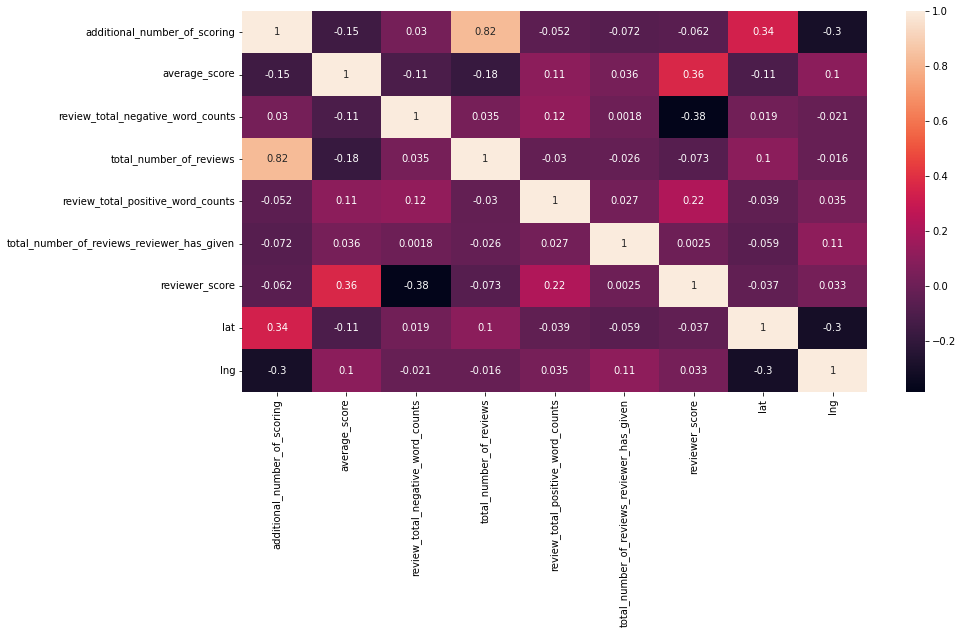

In [22]:
mask_no_test = hotels_eda.reviewer_score > -1
plt.rcParams['figure.figsize'] = (14,7)
plt.xticks(rotation=45)
sns.heatmap(hotels_eda[mask_no_test].corr(), annot=True)

## 2.4. Outliers

In [23]:
# Использование метода describe()
hotels_eda[mask_no_test].describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,386803.000000,386803.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.433430,2.892393
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.460952,4.666227
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214066,-0.143372
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,0.019886
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.841163
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.445799


### 2.4.1. распределение additional_number_of_scoring

/home/daria/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='additional_number_of_scoring'>

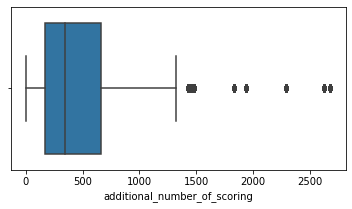

In [24]:
sns.set_theme()
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(data=hotels_eda, x='additional_number_of_scoring')

<AxesSubplot: >

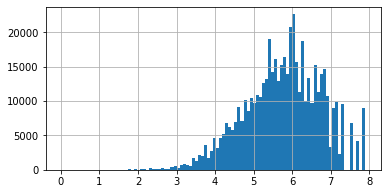

In [25]:
# посмотрим как нормализует переменную логарифмирование
np.log(hotels_eda.additional_number_of_scoring).hist(bins = 100)

<AxesSubplot: xlabel='additional_number_of_scoring', ylabel='reviewer_score'>

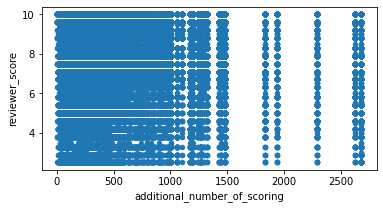

In [26]:
#  ну и заодно глянем на диаграмму рассеивания
hotels_eda[mask_no_test].plot(x='additional_number_of_scoring', y='reviewer_score', kind='scatter')

### 2.4.2. распределение average_score

/home/daria/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='average_score'>

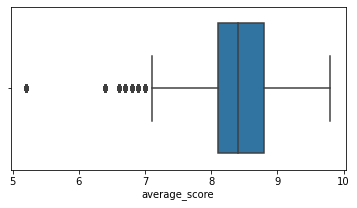

In [27]:
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(data=hotels_eda, x='average_score')

<AxesSubplot: >

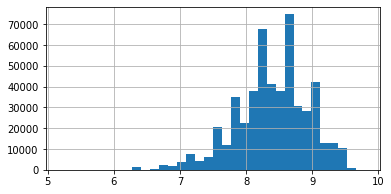

In [28]:
hotels_eda.average_score.hist(bins = 34)

<AxesSubplot: xlabel='average_score', ylabel='reviewer_score'>

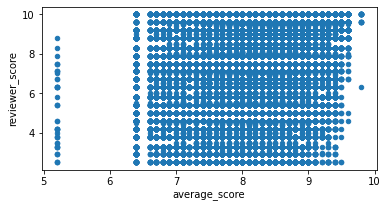

In [29]:
# диаграмма рассеивания
hotels_eda[mask_no_test].plot(x='average_score', y='reviewer_score', kind='scatter')

### 2.4.3. распределение review_total_negative_word_counts

0      127890
2       24647
3       18144
6       17749
5       16809
        ...  
400         1
331         1
398         1
408         1
401         1
Name: review_total_negative_word_counts, Length: 402, dtype: int64


/home/daria/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='review_total_negative_word_counts'>

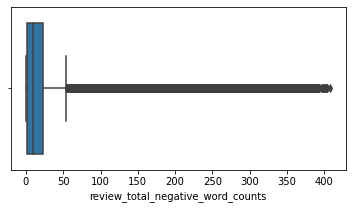

In [30]:
print(hotels_eda.review_total_negative_word_counts.value_counts())
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(data=hotels_eda, x='review_total_negative_word_counts')

<AxesSubplot: >

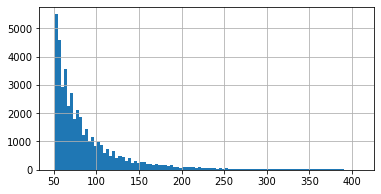

In [31]:
mask_many_negative = hotels_eda.review_total_negative_word_counts > 50
hotels_eda[mask_many_negative].review_total_negative_word_counts.hist(bins = 100)

<AxesSubplot: >

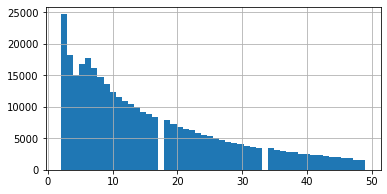

In [33]:
# посмотрю на распределение без нулевых и многословных отзывов
mask_no_zero = hotels_eda.review_total_negative_word_counts > 0
mask_normal_negative = hotels_eda.review_total_negative_word_counts < 50
hotels_eda[mask_no_zero & mask_normal_negative].review_total_negative_word_counts.hist(bins = 50)

In [34]:
# посмотрю сколько вообще нулевых значений
mask_zero_negativ = hotels_eda.review_total_negative_word_counts == 0
hotels_eda[mask_zero_negativ].review_total_negative_word_counts.info()

<class 'pandas.core.series.Series'>
Int64Index: 127890 entries, 3 to 128933
Series name: review_total_negative_word_counts
Non-Null Count   Dtype
--------------   -----
127890 non-null  int64
dtypes: int64(1)
memory usage: 2.0 MB


<AxesSubplot: xlabel='review_total_negative_word_counts', ylabel='reviewer_score'>

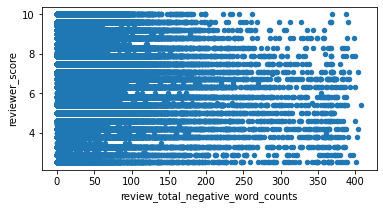

In [35]:
# диаграмма рассеивания
hotels_eda[mask_no_test].plot(x='review_total_negative_word_counts', y='reviewer_score', kind='scatter')

### 2.4.4. распределение total_number_of_reviews

/home/daria/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='total_number_of_reviews'>

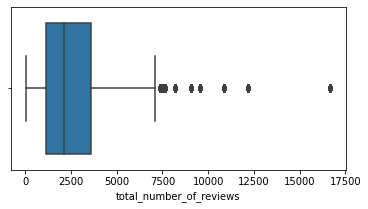

In [36]:
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(data=hotels_eda, x='total_number_of_reviews')

<AxesSubplot: >

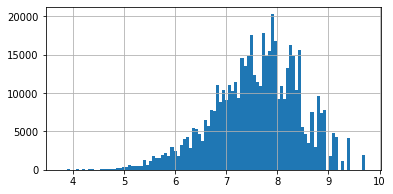

In [37]:
# посмотрим как нормализует переменную логарифмирование
np.log(hotels_eda.total_number_of_reviews).hist(bins = 100)

<AxesSubplot: xlabel='total_number_of_reviews', ylabel='reviewer_score'>

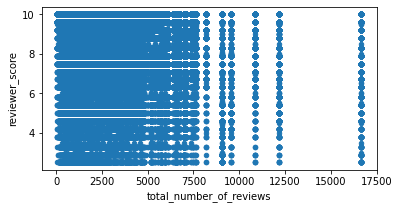

In [38]:
# диаграмма рассеивания
hotels_eda[mask_no_test].plot(x='total_number_of_reviews', y='reviewer_score', kind='scatter')

### 2.4.5. распределение review_total_positive_word_counts

/home/daria/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='review_total_positive_word_counts'>

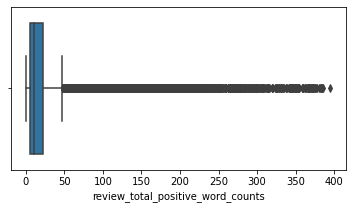

In [39]:
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(data=hotels_eda, x='review_total_positive_word_counts')

<AxesSubplot: >

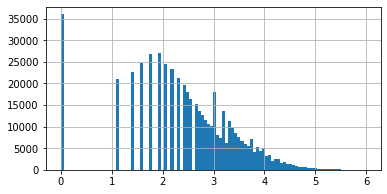

In [40]:
np.log(hotels_eda.review_total_positive_word_counts+1).hist(bins=100)

интересненько, картина похожая с негативными словами, как будто 3 группы наложенных распределений - нулевые, до 50 слов и более 50 слов

<AxesSubplot: xlabel='review_total_positive_word_counts', ylabel='reviewer_score'>

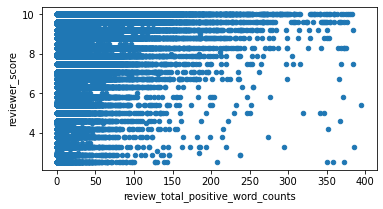

In [41]:
# диаграмма рассеивания
hotels_eda[mask_no_test].plot(x='review_total_positive_word_counts', y='reviewer_score', kind='scatter')

### 2.4.6. распределение total_number_of_reviews_reviewer_has_given

/home/daria/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='total_number_of_reviews_reviewer_has_given'>

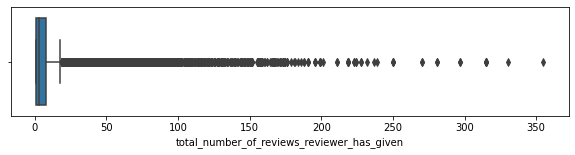

In [42]:
plt.rcParams['figure.figsize'] = (10,2)
sns.boxplot(data=hotels_eda, x='total_number_of_reviews_reviewer_has_given')

<AxesSubplot: >

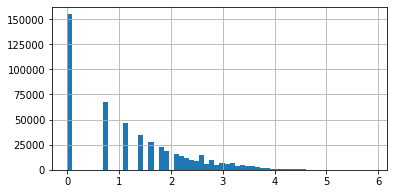

In [43]:
# посмотрим как нормализует переменную логарифмирование
plt.rcParams['figure.figsize'] = (6,3)
np.log(hotels_eda.total_number_of_reviews_reviewer_has_given).hist(bins = 60)

<AxesSubplot: xlabel='total_number_of_reviews_reviewer_has_given', ylabel='reviewer_score'>

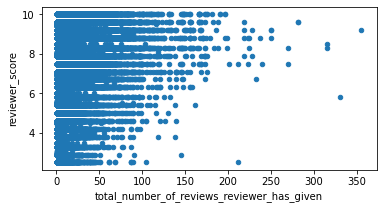

In [44]:
# диаграмма рассеивания
hotels_eda[mask_no_test].plot(x='total_number_of_reviews_reviewer_has_given', 
                              y='reviewer_score', kind='scatter')

## 2.5. Feature engineering

### 2.5.1. Добавим признак расстояние до Парижа

In [45]:
fe_data = hotels_eda.copy()
fe_data['distance'] = fe_data.apply(lambda row: 
                                      haversine(lon1, 
                                                lat1,
                                                lon2 = row['lng'], 
                                                lat2 = row['lat']), 
                                      axis=1)
# по сути признак с расстоянием описывает наши координаты, можем исходные широты/долготы удалить
fe_data.drop(['lat', 'lng'], axis=1, inplace=True)
print(fe_data['distance'].describe())
fe_data.sample(2)

count    515738.000000
mean        444.054477
std         272.075164
min           0.000000
25%         343.000000
50%         346.000000
75%         638.000000
max        1040.000000
Name: distance, dtype: float64


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,distance
1580,31 St Thomas Street Southwark London SE1 9QU U...,732,6/23/2017,9.4,Shangri La Hotel at The Shard London,United Kingdom,I didn t like the bathroom because it was for...,40,2200,Stanning hotel beautfull room with must an am...,11,3,-1.0,"[' Leisure trip ', ' Couple ', ' Superior Shar...",41 days,342
74808,21 rue de Dunkerque 10th arr 75010 Paris France,740,2/9/2017,7.4,Mercure Paris Terminus Nord,United Kingdom,Almost everything rooms smelled of smoke so o...,115,5575,Nothing it was abismal,5,1,-1.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",175 day,3


In [46]:
fe_data.distance.nunique()

72

In [47]:
fe_data.distance.unique()

array([ 344,  345,    2,    5,  430,  645, 1032,  347,  828,  829,  831,
        343,  352,    3, 1034,  830,  427,  428,  346,  425,  342,  339,
        639,    4,  429,  832, 1033,  431,  432,    0,  354,  637,  337,
        350,  426,  338,  340, 1028,    1, 1031,  349,  640,  641,  353,
        424,  348,  632,  433, 1030, 1029, 1036,  826,  644,  341,  634,
       1038,  351,    6,  638,  636, 1035,  837,  825,  635, 1037,  642,
        356, 1040,    7,  827, 1027,  633])

Как видим, весь наш большой датасет сводится к 72 локациям, как раз не далее 1040км от Парижа

### 2.5.2. Поработаем с датами

In [48]:
fe_data = hotels_eda.copy()
# преобразуем тип признака с датой
fe_data.review_date =  pd.to_datetime(fe_data.review_date)
# создам признак с периодом между самым новым и самым старым отзывом по адресу отеля
grp_name = fe_data.groupby(['hotel_address']).review_date.max() - fe_data.groupby(['hotel_address']).review_date.min()
fe_data['date_diff'] = fe_data.hotel_address.apply(lambda x: grp_name[x]).dt.days
# преобразуем признак days_since_review в числовой
fe_data['days_since_review'] = pd.to_numeric(fe_data['days_since_review'].str.replace('\D', ''), errors='coerce')
# выделю из даты отзыва является ли выходным днем
fe_data['is_weekend'] = fe_data.review_date.dt.weekday.apply(lambda x: 1 if x > 4 else 0)
# выделю из даты отзыва день недели
fe_data['wd'] = fe_data.review_date.dt.weekday
# выделю из даты отзыва число месяца
fe_data['md'] = fe_data.review_date.dt.month
# удалю дату отзыва
fe_data.drop('review_date', axis=1, inplace=True)
print(fe_data.info())
fe_data.sample(2)

/tmp/ipykernel_28508/1046290459.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  fe_data['days_since_review'] = pd.to_numeric(fe_data['days_since_review'].str.replace('\D', ''), errors='coerce')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,date_diff,is_weekend,wd,md
47739,Damrak 96 Amsterdam City Center 1012 LP Amster...,451,8.5,Swiss tel Amsterdam,Indonesia,no parking,3,2756,location,2,4,8.3,"[' Leisure trip ', ' Family with older childre...",403,52.373527,4.893304,729,1,6,6
42450,Vondelstraat 18 30 Oud West 1054 GE Amsterdam ...,248,8.0,Hotel Vondel Amsterdam,Ireland,For a business traveler not the best hotel Wi...,56,1952,Location was OK,4,4,4.6,"[' Business trip ', ' Solo traveler ', ' Soute...",233,52.362566,4.877923,729,0,1,12


Посмотрю распределения синтезированных признаков

<AxesSubplot: >

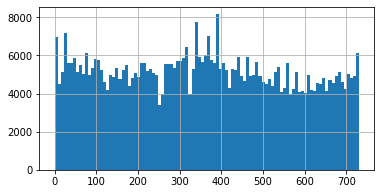

In [49]:
# количество дней после отзыва
fe_data.days_since_review.hist(bins=100)

In [50]:
fe_data.date_diff.value_counts()

730    243437
729     70784
728     41749
727     19780
725     14283
        ...  
95         13
366        13
87         12
555        12
352        10
Name: date_diff, Length: 232, dtype: int64

<AxesSubplot: >

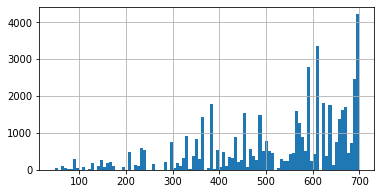

In [51]:
# менее 700 дней между самым старым и свежим отзывами по отношению к адресу
mask_1 = fe_data.date_diff < 700
fe_data[mask_1].date_diff.hist(bins=100)

<AxesSubplot: >

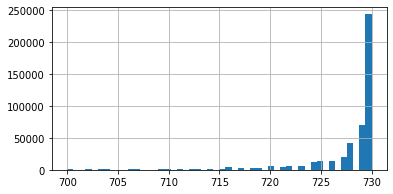

In [52]:
# от 700 и более дней между отзывами по адресу
mask_2 = fe_data.date_diff > 699
fe_data[mask_2].date_diff.hist(bins=50)

Около половины всех значений имеют максимальную разницу между самым первым и самым последним отзывами - 730 дней. Кто бы знал, что это может значить

<AxesSubplot: >

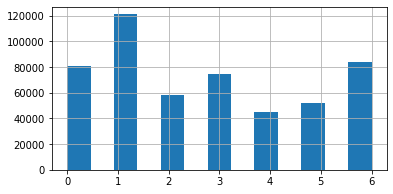

In [53]:
# распределение отзывов по дням недели, 0 - понедельник
fe_data.wd.hist(bins=13)

чаще всего находит вдохновение написать к отелю отзыв по вторникам?

<AxesSubplot: >

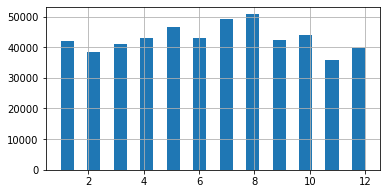

In [54]:
# распределение отзывов по месяцам
fe_data.md.hist(bins=23)

похоже что самые "горячие" для отелей месяцы - май, июль и август, а самый спокойным - ноябрь. Выглядит вполне логично

### 2.5.3. Обработаем тэги

In [55]:
fe_data = hotels_eda.copy()
print(fe_data.tags[0])
# переведем признак с тэгами в список
fe_data.tags = fe_data.tags.str.findall(r"' (\b.*?\b) '")
# создам признак с количеством тегов
fe_data['сount_tags'] = fe_data.tags.apply(lambda x: len(x))

# обработаю теги с использованием библиотеки Counter
temp_list = fe_data.tags.tolist()
temp_Counter = Counter(list_unrar(temp_list))
dict_tags = dict(temp_Counter)
print('Количество уникальных тегов: ', len(list(temp_Counter)))

# имеем 2428 тегов, разделим их на категории по популярности
# список самых популярных тегов
list_of_most_popular_tag = [x[0] for x in temp_Counter.most_common(15)]
# список популярных тегов
list_of_popular_tag = [x[0] for x in temp_Counter.most_common()[15:600]]
# список редких тегов
list_of_rare_tag = [x[0] for x in temp_Counter.most_common()[600:]]
# проверю все ли тэги учла в списках
print('Tag lists sum: ', (len(list_of_most_popular_tag)+len(list_of_popular_tag)+len(list_of_rare_tag)))
# создам признаки на основе популярности тегов
fe_data['rare_tag'] = fe_data.tags.apply(lambda x: 1 if len(set(x) & set(list_of_rare_tag))>0  else 0).astype('float64')
fe_data['popular_tag'] = hotels_eda.tags.apply(lambda x: 1 if len(set(x) & set(list_of_popular_tag))>0  else 0).astype('float64')

# а самые популярные 15 тегов выведем в отдельные категории
for tag in list_of_most_popular_tag:
    fe_data[tag] = fe_data.tags.apply(lambda x: 1 if tag in x else 0 ).astype('float64')

# уберу пробелы в названиях колонок
fe_data.columns = [column.replace(' ','_') for column in fe_data.columns]
print(fe_data.info())
fe_data.sample(2)

0    [' Leisure trip ', ' Couple ', ' Studio Suite ...
0    [' Leisure trip ', ' Couple ', ' Double Room '...
Name: tags, dtype: object
Количество уникальных тегов:  2428
Tag lists sum:  2428
<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,сount_tags,rare_tag,popular_tag,Leisure_trip,Submitted_from_a_mobile_device,Couple,Stayed_1_night,Stayed_2_nights,Solo_traveler,Stayed_3_nights,Business_trip,Group,Family_with_young_children,Stayed_4_nights,Double_Room,Standard_Double_Room,Superior_Double_Room,Family_with_older_children
312874,Delflandlaan 15 Slotervaart 1062 EA Amsterdam ...,947,3/19/2017,8.7,Best Western Premier Hotel Couture,Italy,No Negative,0,8177,Great experience at this property friendly st...,11,2,10.0,"[Leisure trip, Group, Standard Double or Twin ...",137 day,52.351114,4.841163,5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
70546,Rusland 17 Amsterdam City Center 1012 CK Amste...,827,10/28/2015,8.6,Radisson Blu Hotel Amsterdam,United Kingdom,Nothing,2,4593,Recently visited Amsterdam with my mother sis...,57,1,-1.0,"[Leisure trip, Family with young children, Jun...",645 day,52.370247,4.896674,5,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


count    515738.000000
mean          4.569359
std           0.520187
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           6.000000
Name: сount_tags, dtype: float64


<AxesSubplot: >

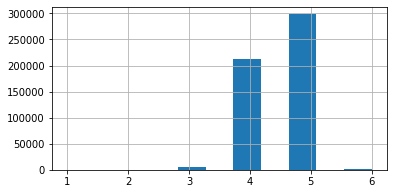

In [56]:
print(fe_data['сount_tags'].describe())
fe_data['сount_tags'].hist(bins = 11)

In [57]:
fe_data['сount_tags'].value_counts()

5    297823
4    211564
3      5505
6       755
2        85
1         6
Name: сount_tags, dtype: int64

<AxesSubplot: xlabel='сount_tags', ylabel='reviewer_score'>

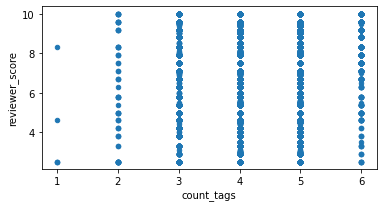

In [58]:
# диаграмма рассеивания
fe_data[mask_no_test].plot(x='сount_tags', y='reviewer_score', kind='scatter')

### 2.5.4. Обработаем тексты отзывов

In [60]:
fe_data = hotels_eda.copy()

sid = SentimentIntensityAnalyzer()

fe_data['neg_scores'] = fe_data['negative_review'].apply(lambda review: sid.polarity_scores(review))
fe_data['pos_scores'] = fe_data['positive_review'].apply(lambda review: sid.polarity_scores(review))

fe_data['neg_compound']  = fe_data['neg_scores'].apply(lambda score_dict: score_dict['compound'])
fe_data['pos_compound']  = fe_data['pos_scores'].apply(lambda score_dict: score_dict['compound'])

fe_data['neg_comp_score'] = fe_data['neg_compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
fe_data['pos_comp_score'] = fe_data['pos_compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

print(fe_data['neg_compound'].describe())
print(fe_data['pos_compound'].describe())
print(fe_data['neg_comp_score'].describe())
print(fe_data['pos_comp_score'].describe())

fe_data.sample(3)

count    515738.000000
mean         -0.209151
std           0.453386
min          -0.998100
25%          -0.709600
50%          -0.177900
75%           0.000000
max           0.996400
Name: neg_compound, dtype: float64
count    515738.000000
mean          0.593533
std           0.342460
min          -0.983200
25%           0.350600
50%           0.708900
75%           0.883400
max           0.999300
Name: pos_compound, dtype: float64
count     515738
unique         2
top          neg
freq      275586
Name: neg_comp_score, dtype: object
count     515738
unique         2
top          pos
freq      508498
Name: pos_comp_score, dtype: object


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,neg_scores,pos_scores,neg_compound,pos_compound,neg_comp_score,pos_comp_score
220630,Moll de Barcelona WTC Ciutat Vella 08039 Barce...,666,6/24/2016,8.5,Eurostars Grand Marina Hotel GL,United States of America,I chose a suite because the picture showed a ...,30,4559,The service from the staff at the front desk ...,17,6,8.8,"[' Leisure trip ', ' Solo traveler ', ' Luxury...",405 day,41.371308,2.181698,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.73, 'pos': 0.27, 'compou...",0.0000,0.5859,pos,pos
195459,50 Berners Street Westminster Borough London W...,260,8/30/2015,9.0,Sanderson A Morgans Hotel,China,No Negative,0,886,i like the general vibe of the hotel and the ...,15,9,10.0,"[' Business trip ', ' Solo traveler ', ' Stand...",704 day,51.517485,-0.137211,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...",-0.7096,0.3612,neg,pos
9178,Gran V a de les Corts Catalanes 322 Sants Mont...,391,10/17/2016,8.8,Ayre Hotel Gran V a,United Kingdom,Boiling water would have helped to make a dec...,14,4887,The breakfast choice was brilliant the servic...,42,3,-1.0,"[' Leisure trip ', ' Couple ', ' Junior Suite ...",290 day,41.373246,2.147435,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.644, 'pos': 0.356, 'comp...",0.0000,0.9569,pos,pos


<AxesSubplot: xlabel='reviewer_score', ylabel='neg_comp_score'>

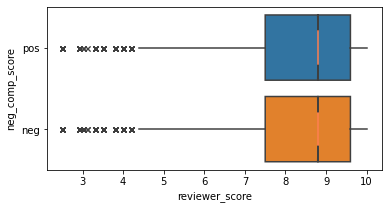

In [61]:
# распределение позитивных и негативных оценок в негативных отзывах
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(
    data=fe_data[mask_no_test], x="reviewer_score", y="neg_comp_score",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},
)

<AxesSubplot: xlabel='reviewer_score', ylabel='pos_comp_score'>

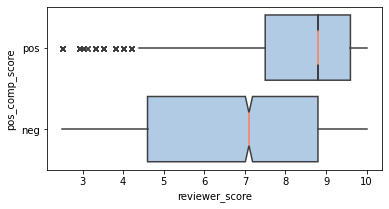

In [62]:
# распределение позитивных и негативных оценок в позитивных отзывах
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(
    data=fe_data[mask_no_test], x="reviewer_score", y="pos_comp_score",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)

### 2.5.5. Обработаю адрес

In [63]:
#fe_data = hotels_eda.copy()
fe_data['location'] = fe_data.hotel_address.str.split().str[-2:].apply(lambda x: '_'.join(x))
print(fe_data.location.unique())
fe_data.location.value_counts()

['United Kingdom' 'Paris France' 'Amsterdam Netherlands' 'Milan Italy'
 'Vienna Austria' 'Barcelona Spain']


United Kingdom           262301
Barcelona Spain           60149
Paris France              59928
Amsterdam Netherlands     57214
Vienna Austria            38939
Milan Italy               37207
Name: location, dtype: int64

<AxesSubplot: >

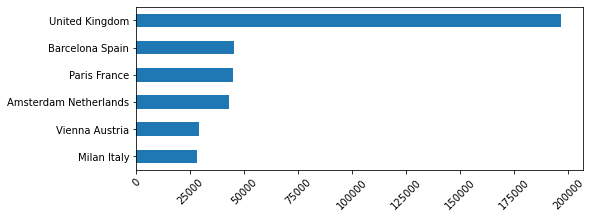

In [64]:
# посмотрим на количественное соотношение отзывов по городам
plt.rcParams['figure.figsize'] = (8,3)
plt.xticks(rotation=45)
fe_data[mask_no_test]['location'].value_counts(ascending=True).plot(kind='barh')

Теперь понятно почему примерно половина значений на всех распределниях выделяются в отдельную группу, это как раз отзывы из Великобритании. Судя по всему у нас представлены столицы, а население Лондона как мегаполиса значительно больше чем в европейских городах.

<AxesSubplot: xlabel='reviewer_score', ylabel='location'>

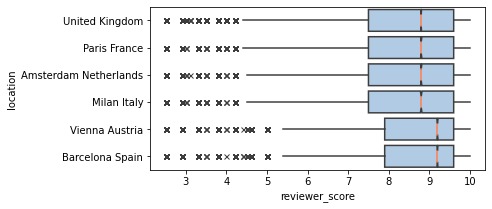

In [65]:
# распределение целевой переменной по городам
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(
    data=fe_data[mask_no_test], x="reviewer_score", y="location",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)


<AxesSubplot: xlabel='reviewer_score', ylabel='location'>

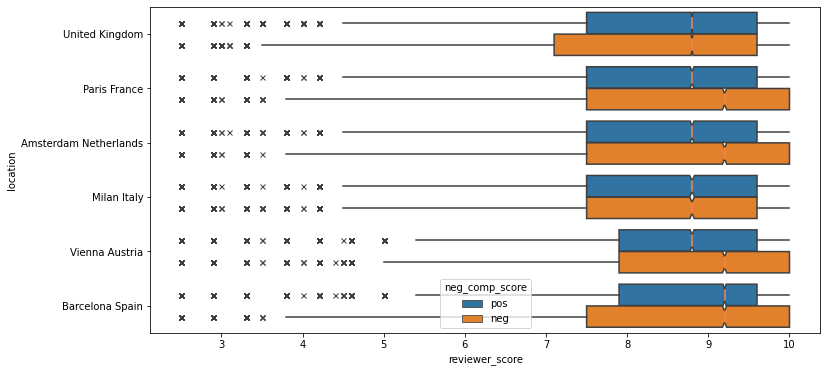

In [66]:
# распределение позитивных и негативных оценок в негативных отзывах по городам
plt.rcParams['figure.figsize'] = (12,6)
sns.boxplot(
    data=fe_data[mask_no_test], x="reviewer_score", y="location",
    hue = 'neg_comp_score',
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},
)

Как то странно, что в Париже, Амстердаме и Вене медианная оценка выше у негативных отзывов. Интересно, завышать оценку после негативного описания это культурные особенности? 

<AxesSubplot: xlabel='reviewer_score', ylabel='location'>

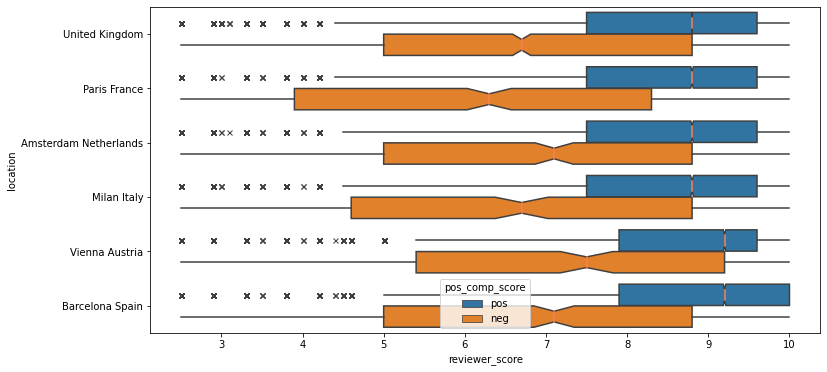

In [67]:
# распределение позитивных и негативных оценок в негативных отзывах по городам
plt.rcParams['figure.figsize'] = (12,6)
sns.boxplot(
    data=fe_data[mask_no_test], x="reviewer_score", y="location",
    hue = 'pos_comp_score',
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},
)

Тут все выглядит более логично, оценка выше у позитивного контекста и ниже у негативного

 Добавлю признак с населением

In [68]:
# население согласно Википедии, тыс.чел
population_dict = {'United Kingdom': 8962, 'Paris France': 2148, 'Amsterdam Netherlands': 873,
                   'Milan Italy': 1379, 'Vienna Austria': 1897, 'Barcelona Spain': 1636}
# добавим признак плотности населения, тыс. чел на км
pop_density_dict = {'United Kingdom': 5.7, 'Paris France': 20.8, 'Amsterdam Netherlands': 4.8,
                   'Milan Italy': 7.6, 'Vienna Austria': 4.5, 'Barcelona Spain': 15.8}

fe_data['population'] = fe_data.apply(lambda row: population_dict[row['location']], axis=1)
fe_data['pop_density'] = fe_data.apply(lambda row: pop_density_dict[row['location']], axis=1)
fe_data.sample(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,neg_scores,pos_scores,neg_compound,pos_compound,neg_comp_score,pos_comp_score,location,population,pop_density
350257,372 Strand Westminster Borough London WC2R 0JJ...,2288,6/17/2017,8.1,Strand Palace Hotel,Sweden,No air conditioning and it was very hot those...,16,9568,Location,3,16,5.8,"[' Business trip ', ' Solo traveler ', ' Cosy ...",47 days,51.511099,-0.120867,"{'neg': 0.145, 'neu': 0.855, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",-0.2960,0.0000,neg,pos,United Kingdom,8962,5.7
179061,202 rue de Rivoli 1st arr 75001 Paris France,297,1/12/2016,8.0,Saint James Albany Paris Hotel Spa,Belgium,Maybe a little bottle of water as compliment ...,13,2868,Nice situation Luxe everywhere,6,2,10.0,"[' Business trip ', ' Solo traveler ', ' Super...",569 day,48.864269,2.330818,"{'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'comp...","{'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...",0.8519,0.4215,pos,pos,Paris France,2148,20.8
188636,Prins Hendrikkade 33 Amsterdam City Center 101...,482,10/6/2016,9.0,art otel Amsterdam,United States of America,No Negative,0,3158,The hotel was very beautiful and the room was...,29,2,10.0,"[' Leisure trip ', ' Group ', ' Art King Room ...",301 day,52.377743,4.897057,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.509, 'pos': 0.491, 'comp...",-0.7096,0.9651,neg,pos,Amsterdam Netherlands,873,4.8


# 3. Preprocessing

In [116]:
# конечная функция полной предобработки датасета для обучения
def preproc_data(df_input: pd.DataFrame) -> pd.DataFrame:
    
    df_output = df_input.copy()
  
    # сохраним исходные индексы в отдельный столбец
    df_output["index"] = df_output.index
    
    # Обработаю координаты
    # заполню пропуски
    df_output['lat'] = df_output['lat'].fillna(df_output['hotel_address'].map(lat_dict))
    df_output['lng'] = df_output['lng'].fillna(df_output['hotel_address'].map(lng_dict))
    
    # определю по координатам расстояние до Парижа
    df_output['distance'] = fe_data.apply(lambda row: haversine(lon1, lat1, lon2 = row['lng'], 
                                                                lat2 = row['lat']), axis=1)
    # по сути признак с расстоянием описывает наши координаты, можем исходные широты/долготы удалить
    df_output.drop(['lat', 'lng'], axis=1, inplace=True)
    
    # Обработка тегов
    # переведем признак с тэгами в список
    df_output['tags_listed'] = df_output.tags.str.findall(r"' (\b.*?\b) '")
    # создам признак с количеством тегов
    df_output['сount_tags'] = df_output.tags_listed.apply(lambda x: len(x))

    # обработаю теги с использованием библиотеки Counter
    temp_list = df_output['tags_listed'].tolist()
    temp_Counter = Counter(list_unrar(temp_list))
    
    # список самых популярных тегов
    list_of_most_popular_tag = [x[0] for x in temp_Counter.most_common(15)]
    # список популярных тегов
    list_of_popular_tag = [x[0] for x in temp_Counter.most_common()[15:600]]
    # список редких тегов
    list_of_rare_tag = [x[0] for x in temp_Counter.most_common()[600:]]
    
    # создам признаки на основе популярности тегов
    df_output['rare_tag'] = df_output.tags_listed.apply(lambda x: 1 if len(set(x) & set(list_of_rare_tag))>0  
                                                 else 0).astype('float64')
    df_output['popular_tag'] = df_output.tags_listed.apply(lambda x: 1 if len(set(x) & set(list_of_popular_tag))>0  
                                                    else 0).astype('float64')

    # а самые популярные 15 тегов выведем в отдельные категории
    for tag in list_of_most_popular_tag:
        df_output[tag] = df_output.tags_listed.apply(lambda x: 1 if tag in x else 0 ).astype('float64')
            
    # удвлю более не нужные столбцы с тегами
    df_output.drop(['tags', 'tags_listed'], axis=1, inplace=True)

    # Обработка временных признаков
    # преобразуем тип признака с датой
    df_output.review_date =  pd.to_datetime(df_output.review_date)
    
    # создам признак с периодом между самым новым и самым старым отзывом по адресу отеля
    grp_name = df_output.groupby(['hotel_address']).review_date.max() - df_output.groupby(['hotel_address']).review_date.min()
    df_output['date_diff'] = df_output.hotel_address.apply(lambda x: grp_name[x]).dt.days
    
    # преобразуем признак days_since_review в числовой
    df_output['days_since_review'] = pd.to_numeric(df_output['days_since_review'].str.split().str[0])
    
    # выделю из даты отзыва является ли выходным днем
    df_output['is_weekend'] = df_output.review_date.dt.weekday.apply(lambda x: 1 if x > 4 else 0)
    # выделю из даты отзыва день недели
    df_output['wd'] = df_output.review_date.dt.weekday
    # выделю из даты отзыва число месяца
    df_output['md'] = df_output.review_date.dt.month
    # удалю дату отзыва
    df_output.drop('review_date', axis=1, inplace=True)
    
    # Обработка адреса
    # Вытащим последние 2 слова адреса с названием города и страны
    df_output['location'] = df_output.hotel_address.str.split().str[-2:].apply(lambda x: '_'.join(x))
    
    # создам признаки с населением города и плотностью населения в нем
    df_output['population'] = df_output.apply(lambda row: population_dict[row['location']], axis=1)
    df_output['pop_density'] = df_output.apply(lambda row: pop_density_dict[row['location']], axis=1)
    
    # удалю адрес
    df_output.drop('hotel_address', axis=1, inplace=True)
    
    #  Обработка текстов отзывов
    # Инициализирую анализатор текста
    sid = SentimentIntensityAnalyzer()
    
    # Анализ текстов позитивных и негативных отзывов
    df_output['neg_scores'] = df_output['negative_review'].apply(lambda review: sid.polarity_scores(review))
    df_output['pos_scores'] = df_output['positive_review'].apply(lambda review: sid.polarity_scores(review))
    
    # Суммарна числовая метрика "позитивности" и "негативности" текста
    # Отзыв более позитивный если значение > 0 и более негативный если < 0
    df_output['neg_compound']  = df_output['neg_scores'].apply(lambda score_dict: score_dict['compound'])
    df_output['pos_compound']  = df_output['pos_scores'].apply(lambda score_dict: score_dict['compound'])

    df_output['is_pos_neg_review'] = df_output['neg_compound'].apply(lambda c: 1 if c >=0 else 0)
    df_output['is_pos_pos_rev'] = df_output['pos_compound'].apply(lambda c: 1 if c >=0 else 0)

    # удалю тексты отзывов и их метрики после анализа
    df_output.drop(['negative_review', 'positive_review', 'neg_scores', 'pos_scores'], axis=1, inplace=True)
    
    
    # уберу пробелы в названиях колонок
    df_output.columns = [column.replace(' ','_') for column in df_output.columns]    
    # вернем исходные индексы
    df_output.set_index('index',inplace=True)
        
    return df_output


In [117]:
%%time

# Первым делом объединяем выборки
combined_data = join_df(df_train, df_test)

# Затем используем нашу функцию предобработки
combined_data = preproc_data(combined_data)

display(combined_data.info())
combined_data.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   total_number_of_reviews                     515738 non-null  int64  
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   days_since_review                           515738 non-null  int64  
 

None

CPU times: user 3min 20s, sys: 1.38 s, total: 3min 22s
Wall time: 3min 22s


,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,distance,сount_tags,rare_tag,popular_tag,Leisure_trip,Submitted_from_a_mobile_device,Couple,Stayed_1_night,Stayed_2_nights,Solo_traveler,Stayed_3_nights,Business_trip,Group,Family_with_young_children,Stayed_4_nights,Double_Room,Standard_Double_Room,Superior_Double_Room,Family_with_older_children,date_diff,is_weekend,wd,md,location,population,pop_density,neg_compound,pos_compound,is_pos_neg_review,is_pos_pos_rev
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,581,8.4,The May Fair Hotel,United Kingdom,3,1994,4,7,10.0,531,344,5,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,729,0,4,2,United_Kingdom,8962,5.7,0.0000,0.5859,1,1
1,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,3,1361,2,14,6.3,203,345,4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,730,0,3,1,United_Kingdom,8962,5.7,-0.4767,0.0000,0,1


In [118]:
%%time

# Закодируем оставшиеся нечисловые признаки
combined_data = code_data(combined_data)

# столбцы с числовыми данными для нормализации
num_cols = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 
            'total_number_of_reviews', 'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'distance', 
           'date_diff', 'population']

# нормализуем все столбцы с числовыми данными
for i  in list(combined_data.columns):
    if i in num_cols:
        combined_data[i] = RobustScaler_column(i)
        
# стандартизирую все значения
MinMaxScaler_column
for i  in list(combined_data.columns):
    if i not in ['reviewer_score']:
        combined_data[i] = MinMaxScaler_column(i)
        

print(combined_data.info())
combined_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 62 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  float64
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  float64
 3   total_number_of_reviews                     515738 non-null  float64
 4   review_total_positive_word_counts           515738 non-null  float64
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 6   reviewer_score                              515738 non-null  float64
 7   days_since_review                           515738 non-null  float64
 8   distance                                    515738 non-null  float64
 9   сount_tags                                  515738 non-null  float64
 

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,distance,сount_tags,rare_tag,popular_tag,Leisure_trip,Submitted_from_a_mobile_device,Couple,Stayed_1_night,Stayed_2_nights,Solo_traveler,Stayed_3_nights,Business_trip,Group,Family_with_young_children,Stayed_4_nights,Double_Room,Standard_Double_Room,Superior_Double_Room,Family_with_older_children,date_diff,is_weekend,wd,md,population,pop_density,neg_compound,pos_compound,is_pos_neg_review,is_pos_pos_rev,location_United_Kingdom,location_Paris_France,location_Amsterdam_Netherlands,location_Milan_Italy,location_Vienna_Austria,location_Barcelona_Spain,hotel_name_0,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
260478,0.721746,0.760870,0.000000,0.447946,0.048101,0.011299,9.6,0.001370,0.328846,0.6,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.333333,0.636364,1.0,0.07362,0.144648,0.708550,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
256832,0.117120,0.913043,0.000000,0.058820,0.012658,0.000000,8.8,0.815068,0.330769,0.6,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.998536,0.0,0.500000,1.000000,1.0,0.07362,0.144648,0.744464,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2101,0.853040,0.630435,0.019608,0.572863,0.005063,0.045198,6.3,0.554795,0.330769,0.8,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.666667,0.454545,1.0,0.07362,0.261419,0.495939,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# 4. Modelling

## 4.1. Splitting

In [119]:
train_data, test_data = split_df(combined_data)
# Проверки
print('train_data:', train_data.shape)
print('test_data:', test_data.shape)
print('Empty values in train:', train_data.isna().any().sum())
print('Empty values in test:', test_data.isna().any().sum())

train_data: (386803, 62)
test_data: (128935, 61)
Empty values in train: 0
Empty values in test: 0


In [120]:
y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [121]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [122]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 61), (386803, 62), (386803, 61), (309442, 61), (77361, 61))

## 4.2. Training and predicting

In [123]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [124]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [125]:
%%time

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


CPU times: user 16min 12s, sys: 810 ms, total: 16min 13s
Wall time: 2min 12s


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


In [127]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12560783921506988


## 4.3. Features evaluating

<AxesSubplot: >

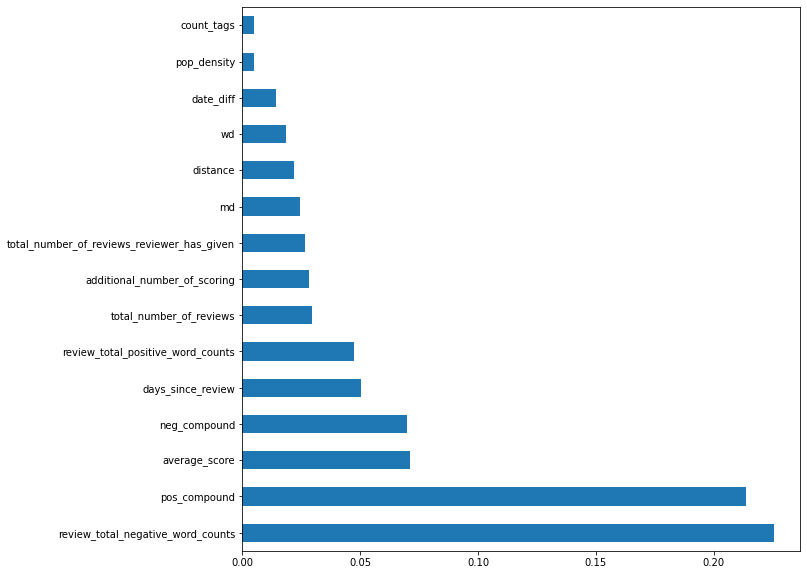

In [128]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

## 4.4. Блок подбора оптимальных параметров для модели

In [132]:
# # блок тестирования оптимального набора
list_ofAllColumnsSortImportant = list(feat_importances.nlargest(len(train_data.columns)-1).index)
MAPE = 0.12560783921506988
min_MAPE = round(MAPE,3)
print(f"min_MAPE = {min_MAPE}")
remove_list = []
log = []
delta =0.002

for i in range(0,len(list_ofAllColumnsSortImportant),1):
    col = list_ofAllColumnsSortImportant[i]
    print(f"{i}.{col}")
    ###

    y = train_data.reviewer_score.values            # наш таргет
    X = train_data.drop(['reviewer_score']+[col], axis=1)

    # Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
    # выделим 20% данных на валидацию (параметр test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
    
    model_ = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
    model_.fit(X_train, y_train)

    y_pred = model_.predict(X_test)
    
    temp_MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred)
     ###
    print(temp_MAPE)
    log.append([col, temp_MAPE])
    if round(temp_MAPE,3) <= min_MAPE-delta:
        remove_list.append(col)
        print(f"удаляем:= {col}")
    else:
        print(f"не удаляем:= {col}")
print(f"i={i}")
print(f"remove_list: {remove_list}")
print(f"log_list: {log}")

min_MAPE = 0.126
0.review_total_negative_word_counts


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.13493040577876403
не удаляем:= review_total_negative_word_counts
1.pos_compound


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12951023655984314
не удаляем:= pos_compound
2.average_score


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12987588601823438
не удаляем:= average_score
3.neg_compound


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.12754005493166307
не удаляем:= neg_compound
4.days_since_review


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.12570553289257128
не удаляем:= days_since_review
5.review_total_positive_word_counts


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12800797788802143
не удаляем:= review_total_positive_word_counts
6.total_number_of_reviews


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12554249076956406
не удаляем:= total_number_of_reviews
7.additional_number_of_scoring


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.1255400192189861
не удаляем:= additional_number_of_scoring
8.total_number_of_reviews_reviewer_has_given


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12573493907909822
не удаляем:= total_number_of_reviews_reviewer_has_given
9.md


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.1256281855387528
не удаляем:= md
10.distance


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.1256216337363752
не удаляем:= distance
11.wd


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12556178922197517
не удаляем:= wd
12.date_diff


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.12555563136066136
не удаляем:= date_diff
13.pop_density


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12562679786661315
не удаляем:= pop_density
14.сount_tags


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12564303807635707
не удаляем:= сount_tags
15.Couple


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12560192147671953
не удаляем:= Couple
16.Stayed_1_night


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.12559756890392199
не удаляем:= Stayed_1_night
17.population


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12558722674917067
не удаляем:= population
18.Stayed_2_nights


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.12559907375500665
не удаляем:= Stayed_2_nights
19.reviewer_nationality_5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12560690038191424
не удаляем:= reviewer_nationality_5
20.hotel_name_4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.12561647159462672
не удаляем:= hotel_name_4
21.hotel_name_5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.12560288036178927
не удаляем:= hotel_name_5
22.hotel_name_8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.1255761015525684
не удаляем:= hotel_name_8
23.hotel_name_7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12561571276518155
не удаляем:= hotel_name_7
24.hotel_name_6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.1255479609498327
не удаляем:= hotel_name_6
25.hotel_name_10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12557667867835437
не удаляем:= hotel_name_10
26.reviewer_nationality_4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12568232391365133
не удаляем:= reviewer_nationality_4
27.reviewer_nationality_6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12564798051969978
не удаляем:= reviewer_nationality_6
28.hotel_name_3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12558901101440323
не удаляем:= hotel_name_3
29.hotel_name_9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


0.1255849321467723
не удаляем:= hotel_name_9
30.reviewer_nationality_7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12557738167709795
не удаляем:= reviewer_nationality_7
31.reviewer_nationality_3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12559618451168275
не удаляем:= reviewer_nationality_3
32.Solo_traveler


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.12565542331812665
не удаляем:= Solo_traveler
33.hotel_name_2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12556242925695058
не удаляем:= hotel_name_2
34.reviewer_nationality_2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.1256879899421473
не удаляем:= reviewer_nationality_2
35.Stayed_3_nights


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.1255426963660256
не удаляем:= Stayed_3_nights
36.Group


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12562129190833868
не удаляем:= Group
37.Family_with_young_children


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.12558890784096766
не удаляем:= Family_with_young_children
38.Leisure_trip


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.1256057371727671
не удаляем:= Leisure_trip
39.Submitted_from_a_mobile_device


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.12567823226930439
не удаляем:= Submitted_from_a_mobile_device
40.hotel_name_1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.1256068185966289
не удаляем:= hotel_name_1
41.Business_trip


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12555650908159646
не удаляем:= Business_trip
42.popular_tag


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12562094009805708
не удаляем:= popular_tag
43.Stayed_4_nights


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.1255861548641893
не удаляем:= Stayed_4_nights
44.reviewer_nationality_1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12566794376625876
не удаляем:= reviewer_nationality_1
45.Standard_Double_Room


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12560830890524435
не удаляем:= Standard_Double_Room
46.Superior_Double_Room


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12561382436358137
не удаляем:= Superior_Double_Room
47.Double_Room


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.1255602909848883
не удаляем:= Double_Room
48.Family_with_older_children


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.12560674871282876
не удаляем:= Family_with_older_children
49.is_weekend


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12560604535387687
не удаляем:= is_weekend
50.rare_tag


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


0.12565745800402017
не удаляем:= rare_tag
51.hotel_name_0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12562283001931465
не удаляем:= hotel_name_0
52.location_Milan_Italy


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12558930898732573
не удаляем:= location_Milan_Italy
53.location_Barcelona_Spain


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12557641215668455
не удаляем:= location_Barcelona_Spain
54.is_pos_neg_review


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.12560930553789995
не удаляем:= is_pos_neg_review
55.location_United_Kingdom


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12559306862601047
не удаляем:= location_United_Kingdom
56.location_Amsterdam_Netherlands


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12557471054825892
не удаляем:= location_Amsterdam_Netherlands
57.location_Paris_France


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.12561190846687964
не удаляем:= location_Paris_France
58.is_pos_pos_rev


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12560991289914514
не удаляем:= is_pos_pos_rev
59.location_Vienna_Austria


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.12562338391085276
не удаляем:= location_Vienna_Austria
60.reviewer_nationality_0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


0.12563872934033476
не удаляем:= reviewer_nationality_0
i=60
remove_list: []
log_list: [['review_total_negative_word_counts', 0.13493040577876403], ['pos_compound', 0.12951023655984314], ['average_score', 0.12987588601823438], ['neg_compound', 0.12754005493166307], ['days_since_review', 0.12570553289257128], ['review_total_positive_word_counts', 0.12800797788802143], ['total_number_of_reviews', 0.12554249076956406], ['additional_number_of_scoring', 0.1255400192189861], ['total_number_of_reviews_reviewer_has_given', 0.12573493907909822], ['md', 0.1256281855387528], ['distance', 0.1256216337363752], ['wd', 0.12556178922197517], ['date_diff', 0.12555563136066136], ['pop_density', 0.12562679786661315], ['сount_tags', 0.12564303807635707], ['Couple', 0.12560192147671953], ['Stayed_1_night', 0.12559756890392199], ['population', 0.12558722674917067], ['Stayed_2_nights', 0.12559907375500665], ['reviewer_nationality_5', 0.12560690038191424], ['hotel_name_4', 0.12561647159462672], ['hotel_name_5

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


### log_list
min_MAPE = 0.126
log_list: [['review_total_negative_word_counts', 0.13493040577876403], ['pos_compound', 0.12951023655984314], ['average_score', 0.12987588601823438], ['neg_compound', 0.12754005493166307], ['days_since_review', 0.12570553289257128], ['review_total_positive_word_counts', 0.12800797788802143], ['total_number_of_reviews', 0.12554249076956406], ['additional_number_of_scoring', 0.1255400192189861], ['total_number_of_reviews_reviewer_has_given', 0.12573493907909822], ['md', 0.1256281855387528], ['distance', 0.1256216337363752], ['wd', 0.12556178922197517], ['date_diff', 0.12555563136066136], ['pop_density', 0.12562679786661315], ['сount_tags', 0.12564303807635707], ['Couple', 0.12560192147671953], ['Stayed_1_night', 0.12559756890392199], ['population', 0.12558722674917067], ['Stayed_2_nights', 0.12559907375500665], ['reviewer_nationality_5', 0.12560690038191424], ['hotel_name_4', 0.12561647159462672], ['hotel_name_5', 0.12560288036178927], ['hotel_name_8', 0.1255761015525684], ['hotel_name_7', 0.12561571276518155], ['hotel_name_6', 0.1255479609498327], ['hotel_name_10', 0.12557667867835437], ['reviewer_nationality_4', 0.12568232391365133], ['reviewer_nationality_6', 0.12564798051969978], ['hotel_name_3', 0.12558901101440323], ['hotel_name_9', 0.1255849321467723], ['reviewer_nationality_7', 0.12557738167709795], ['reviewer_nationality_3', 0.12559618451168275], ['Solo_traveler', 0.12565542331812665], ['hotel_name_2', 0.12556242925695058], ['reviewer_nationality_2', 0.1256879899421473], ['Stayed_3_nights', 0.1255426963660256], ['Group', 0.12562129190833868], ['Family_with_young_children', 0.12558890784096766], ['Leisure_trip', 0.1256057371727671], ['Submitted_from_a_mobile_device', 0.12567823226930439], ['hotel_name_1', 0.1256068185966289], ['Business_trip', 0.12555650908159646], ['popular_tag', 0.12562094009805708], ['Stayed_4_nights', 0.1255861548641893], ['reviewer_nationality_1', 0.12566794376625876], ['Standard_Double_Room', 0.12560830890524435], ['Superior_Double_Room', 0.12561382436358137], ['Double_Room', 0.1255602909848883], ['Family_with_older_children', 0.12560674871282876], ['is_weekend', 0.12560604535387687], ['rare_tag', 0.12565745800402017], ['hotel_name_0', 0.12562283001931465], ['location_Milan_Italy', 0.12558930898732573], ['location_Barcelona_Spain', 0.12557641215668455], ['is_pos_neg_review', 0.12560930553789995], ['location_United_Kingdom', 0.12559306862601047], ['location_Amsterdam_Netherlands', 0.12557471054825892], ['location_Paris_France', 0.12561190846687964], ['is_pos_pos_rev', 0.12560991289914514], ['location_Vienna_Austria', 0.12562338391085276], ['reviewer_nationality_0', 0.12563872934033476]]

## 4.5. Predict submission

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
list(sample_submission)

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)